# EX 1 Week 2:
## Supernovae and accelerated expansion

## Real Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import camb as camb
import random as random

In [2]:
pars = camb.CAMBparams()
Omegam=0.3
pars.set_cosmology(H0=70.0, ombh2=0.05*(70.0/100)**2, omch2=(Omegam-0.05)*(70.0/100)**2);
# set_cosmology wants the PHYSICAL DENSITIES, that is the density parameter multiplied by (H0/100)^2
# camb prende H0 in km/s/Mpc, quindi non serve più dividere per c

# calculate background results:
results = camb.get_background(pars)

Importing data and covariance

In [3]:
data = np.loadtxt('data.txt', dtype=np.double) #taglia delle cifre, non trovo tipo con più precisione
#print(data)
redshifts=data[:,0]
magnitudes=data[:,1]
Sigma= np.loadtxt('covariance.txt', dtype=np.double)

We need to:
1. calculate the theoretical luminosity distances predicted by the cosmological model without radiation or curvature
2. derive the luminosity distances from the data
3. the only free parameter is $\Omega_m$ because $\Omega_{DE}=1-\Omega_m$ is fixed
4. perform a likelihood fit to determine $\Omega_m$

Text(0, 0.5, '$\\mu(z)$')

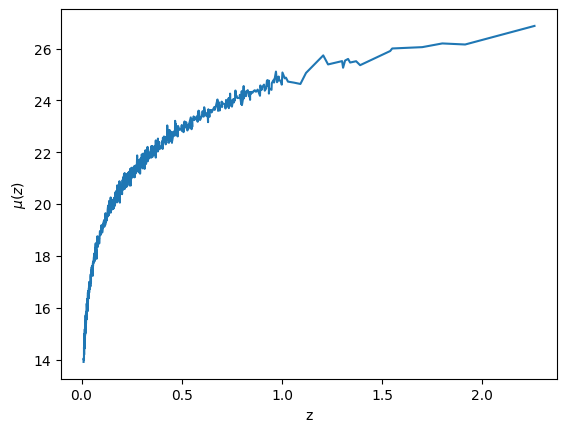

In [4]:
plt.plot(redshifts, magnitudes,label='$\mu(z)$')
plt.xlabel('z')
plt.ylabel('$\mu(z)$')

I calculate the expected distances from theory using the code from Exercise 1: the following relations hold
$\chi(z)=\int_0^z \frac{1}{H(z')}dz'$

$D_L(z)=\chi(z)(1+z)$

$\Omega_{DE}=1-\Omega_m$

In this section, we define the key cosmological functions needed to compute theoretical predictions for supernova observations:
- The Hubble parameter $H(z)$ as a function of redshift and matter density.
- The comoving radial distance $\chi(z)$, which is the integral of $1/H(z)$ from $0$ to $z$.
- The luminosity distance $D_L(z)$, which relates to how bright a supernova appears.
- The theoretical distance modulus $\mu_{teo}(z)$, which is the main observable compared to supernova data.

These functions allow us to model the expansion history of the Universe and connect theory to observations.

In [5]:
# define parameters:

H0 = 70.0 / (299792)

# define function computing Hubble rate, cosmic time
def H(z, Omegam):
    return np.sqrt(H0**2*(Omegam*(1+z)**3+(1-Omegam)))
# define function to compute comoving radial distance:
def chi(z, Omegam):
    return integrate.quad(lambda x: 1./H(x, Omegam), 0, z)[0]
def D_L(z, Omegam):
    return chi(z,Omegam)*(1+z)
def mu_teo(z,Omegam):
    return 5*np.log10(D_L(z,Omegam))

Text(0, 0.5, '$H(z)$')

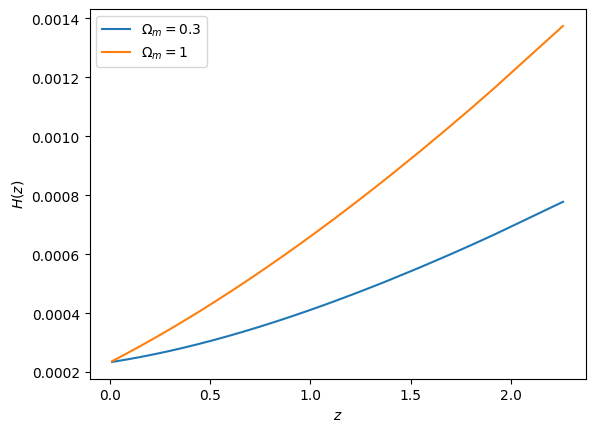

In [6]:
plt.plot(redshifts, [H(z,0.3) for z in redshifts], label='$\Omega_m=0.3$')
plt.plot(redshifts, [H(z,1) for z in redshifts], label='$\Omega_m=1$')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')

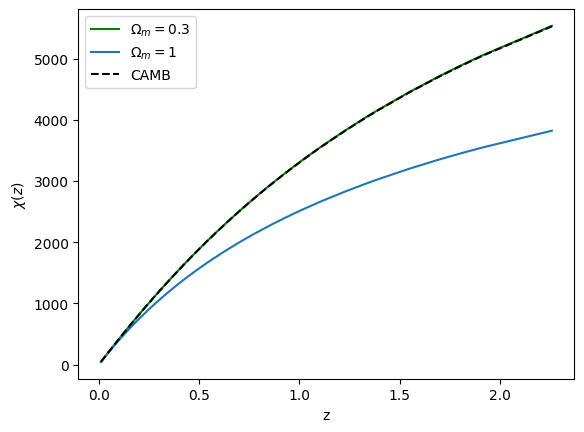

In [7]:
plt.plot(redshifts, [chi(z,0.3) for z in redshifts], label='$ \Omega_m=0.3$', color='green')
plt.plot(redshifts, [chi(z,1.) for z in redshifts], label='$ \Omega_m=1$')

chi_true = results.comoving_radial_distance(redshifts)

plt.plot(redshifts, chi_true,linestyle='--', label='CAMB', color='black')
plt.xlabel('z')
plt.ylabel('$\chi(z)$')
plt.legend()


If I have less matter and more cosmological constant, I expect the proper distances to be higher. I plot the measured magnitudes and those predicted by the model with $\Omega_m=0.3$.

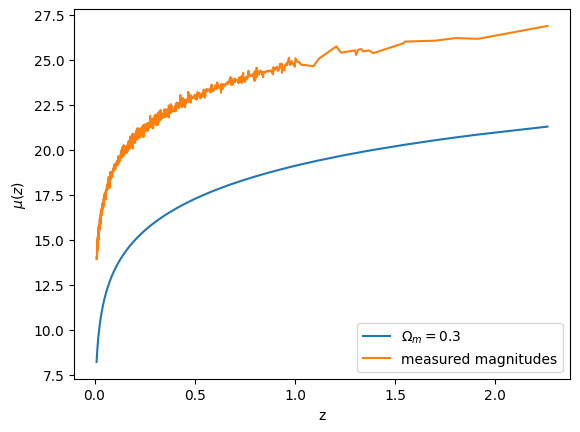

In [8]:
plt.plot(redshifts, [mu_teo(z, 0.3) for z in redshifts], label='$ \Omega_m=0.3$')
#plt.plot(redshifts, [mu_teo(z, 1) for z in redshifts], label='$ \Omega_m=1$')
plt.plot(redshifts, magnitudes, label='measured magnitudes')
plt.xlabel('z')
plt.ylabel('$\mu (z)$')
plt.legend()

Define the likelihood, marginalized on the absolute magnitude 

In [9]:
def logL(data,theory,inverse):
    v=data-theory
    one=np.ones_like(v)
    return -0.5*v.dot(inverse).dot(v)+0.5*(one.dot(inverse).dot(v))**2/(one.dot(inverse).dot(one))

def L(data,theory, inverse):
    return np.exp(logL(data,theory,inverse))

Text(0, 0.5, 'logL')

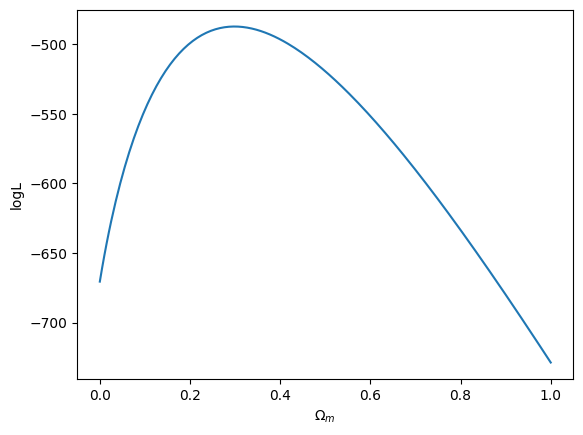

In [10]:
inverse=np.linalg.inv(Sigma)  ##computing inverse covariance
omegas=np.linspace(0,1,200)
L=[]
for o in omegas:
    theory=[mu_teo(z,o) for z in redshifts]
    L.append(logL(magnitudes, theory, inverse))

plt.plot(omegas, L)
plt.xlabel('$\Omega_m$')
plt.ylabel('logL')


In [11]:
OmegaBest = omegas[L.index(max(L))]
print ('L is max for $\Omega_m$=', OmegaBest)

L is max for $\Omega_m$= 0.2964824120603015


Text(0, 0.5, 'L')

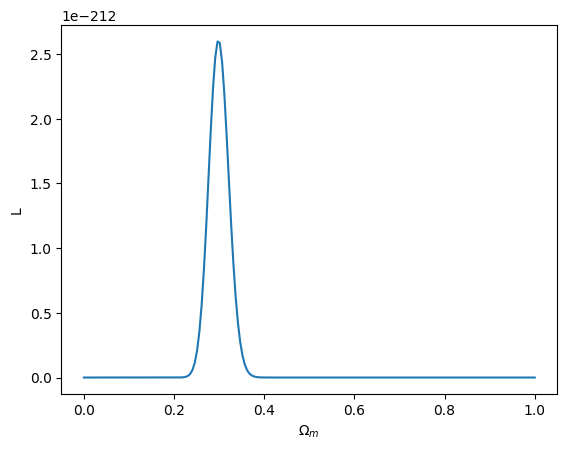

In [12]:
L=np.exp(L)

plt.plot(omegas, L)
plt.xlabel('$\Omega_m$')
plt.ylabel('L')

Compute omega with MLE

In [29]:
# Find the value of Omega_m that maximizes the likelihood
max_idx = np.argmax(L)
Omega_m_max = omegas[max_idx]
print(f"Maximum likelihood at Omega_m = {Omega_m_max}")

Maximum likelihood at Omega_m = 0.2964824120603015


In [30]:
from numpy import gradient

# Compute the second derivative of log-likelihood at the maximum

logL_values = np.log(L)
second_derivative = gradient(gradient(logL_values, omegas), omegas)
error_estimate = 1 / np.sqrt(-second_derivative[max_idx])

print(f"Estimated error on Omega_m: {error_estimate}")

Estimated error on Omega_m: 0.021802520803724187


In [31]:
print('relative error %=', error_estimate/Omega_m_max*100)

relative error %= 7.35373159312053


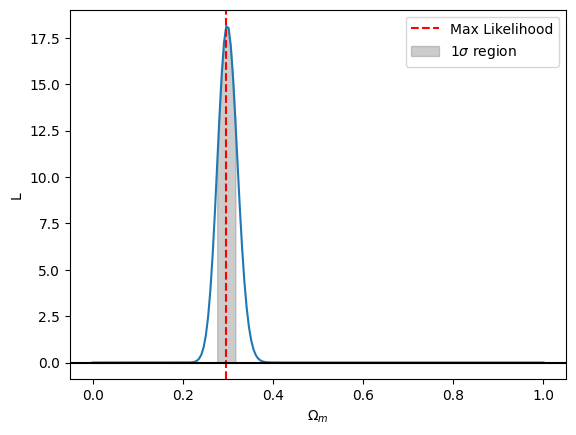

In [44]:
plt.plot(omegas, L)
plt.xlabel('$\Omega_m$')
plt.ylabel('L')
plt.axvline(Omega_m_max, color='red', linestyle='--', label='Max Likelihood')
plt.fill_between(
    omegas,
    L,
    where=(omegas >= Omega_m_max - error_estimate) & (omegas <= Omega_m_max + error_estimate),
    color='grey',
    alpha=0.4,
    label='$1\sigma$ region'
)
plt.legend()
plt.axhline(0, color='black', linestyle='-')

In [46]:
# check the mean of the normalized likelihood
mean = np.sum(omegas * L) / np.sum(L)
RMS = np.sqrt(np.sum((omegas - mean)**2 * L) / np.sum(L))
print('mean=', mean)
print('RMS=', RMS)
print('relative error %=', RMS/mean*100)

mean= 0.29970000425912185
RMS= 0.021948761709520245
relative error %= 7.3235773765766305
